In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
import math
import graphviz
pd.options.display.max_colwidth = 100
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 300)

In [13]:
data_dir = '../../Data/noah/'
data = pd.read_csv(data_dir + 'prepared_data_31Dec2018_2visits.csv')
data.head()

/Users/ruth/miniconda3/envs/vetAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Patient Code,ALP IU/L visit 1,ALT IU/L visit 1,ARC x 1012/L visit 1,AST IU/L visit 1,Alb g/L visit 1,Amylase IU/L visit 1,An. gap mmol/L visit 1,BCS visit 1,BOHB mmol/L visit 1,BUN mmol/L visit 1,Band % visit 1,Band Neu x 109/L visit 1,Baso % visit 1,Basophil x 109/L visit 1,Bicarb mmol/L visit 1,CK IU/L visit 1,Ca mmol/L visit 1,Chol mmol/L visit 1,Cl mmol/L visit 1,Creat umol/L visit 1,DS visit 1,Eosin % visit 1,Eosin. x 109/L visit 1,GammaGT IU/L visit 1,Glob g/L visit 1,Glucose mmol/L visit 1,Hct L/L visit 1,Hgb g/L visit 1,K mmol/L visit 1,Lipase IU/L visit 1,Lymph x 109/L visit 1,Lymph % visit 1,MCH pg visit 1,MCHC g/L visit 1,MCV fl visit 1,Metamyel % visit 1,Mono % visit 1,Monocyte x 109/L visit 1,Myelocyt % visit 1,Na mmol/L visit 1,Na:K visit 1,Neutr % visit 1,Others % visit 1,Phos mmol/L visit 1,Platelet x 109/L visit 1,RCC x 1012/L visit 1,Sam. app visit 1,Seg Neut x 109/L visit 1,T solids g/L visit 1,Tbili umol/L visit 1,Tot CO2 mmol/L visit 1,Tot Prot g/L visit 1,Total T4 visit 1,Ur Pr:Cr visit 1,Ur prot g/L visit 1,Ur. crea umol/L visit 1,Urea mmol/L visit 1,WC Count x 109/L visit 1,Weight visit 1,retic % visit 1,sdma visit 1,temp visit 1,age at test visit 1,Sex_Female visit 1,Sex_Male visit 1,Sex_nan visit 1,Desexed?_No visit 1,Desexed?_Yes visit 1,Desexed?_nan visit 1,Pathology_pathology visit 1,Pathology_nan visit 1,CKD? visit 1,CKD? visit 2
0,0,edd17b9a8b12d531af032d47be8423d5e836f2efffe4edc4abf5a4278d7dec3d,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.00,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,2591.0,0,1,0,0,1,0,1,0,Unknown,Unknown
1,1,edd17b9a8b12d531af032d47be8423d5e836f2efffe4edc4abf5a4278d7dec3d,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.00,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,2594.0,0,1,0,0,1,0,0,1,Unknown,no CKD
2,2,edd17b9a8b12d531af032d47be8423d5e836f2efffe4edc4abf5a4278d7dec3d,23.0,33.0,0.02 ,18.0,28.0,0.0,14.9,0.0,0.0,7.9,0.0,0,0.2,0.01,0.0,96.0,2.64,5.5,117.0,95.0,0,2.9,0.18 ,5.0,39.0,5.8,0.35 ,115 ,4.4,0.0,2.1 ,34.5,14.1 ,330 ,42.9 ,0,1.6,0.10 ,0.0,149.0,0.0,60.7,0.0,1.51,0,8.12 ,0,3.7 ,0,3.0,21.5,67.0,22.0,0.0,0.0,0.0,0.0,6.15 ,0,0.28 ,0.0,0,2921.0,0,1,0,0,1,0,1,0,no CKD,Unknown
3,3,edd17b9a8b12d531af032d47be8423d5e836f2efffe4edc4abf5a4278d7dec3d,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.00,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,3096.0,0,1,0,0,1,0,0,1,Unknown,Unknown
4,4,edd17b9a8b12d531af032d47be8423d5e836f2efffe4edc4abf5a4278d7dec3d,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.00,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,3114.0,0,1,0,0,1,0,0,1,Unknown,Unknown


In [14]:
data['CKD? visit 1'].value_counts()

Unknown    15212
no CKD       128
CKD           43
Name: CKD? visit 1, dtype: int64

In [15]:
data['CKD? visit 2'].value_counts()

Unknown    15266
no CKD        92
CKD           25
Name: CKD? visit 2, dtype: int64

In [17]:
data[data['CKD? visit 1']=='CKD']

,Unnamed: 0,Patient Code,ALP IU/L visit 1,ALT IU/L visit 1,ARC x 1012/L visit 1,AST IU/L visit 1,Alb g/L visit 1,Amylase IU/L visit 1,An. gap mmol/L visit 1,BCS visit 1,BOHB mmol/L visit 1,BUN mmol/L visit 1,Band % visit 1,Band Neu x 109/L visit 1,Baso % visit 1,Basophil x 109/L visit 1,Bicarb mmol/L visit 1,CK IU/L visit 1,Ca mmol/L visit 1,Chol mmol/L visit 1,Cl mmol/L visit 1,Creat umol/L visit 1,DS visit 1,Eosin % visit 1,Eosin. x 109/L visit 1,GammaGT IU/L visit 1,Glob g/L visit 1,Glucose mmol/L visit 1,Hct L/L visit 1,Hgb g/L visit 1,K mmol/L visit 1,Lipase IU/L visit 1,Lymph x 109/L visit 1,Lymph % visit 1,MCH pg visit 1,MCHC g/L visit 1,MCV fl visit 1,Metamyel % visit 1,Mono % visit 1,Monocyte x 109/L visit 1,Myelocyt % visit 1,Na mmol/L visit 1,Na:K visit 1,Neutr % visit 1,Others % visit 1,Phos mmol/L visit 1,Platelet x 109/L visit 1,RCC x 1012/L visit 1,Sam. app visit 1,Seg Neut x 109/L visit 1,T solids g/L visit 1,Tbili umol/L visit 1,Tot CO2 mmol/L visit 1,Tot Prot g/L visit 1,Total T4 visit 1,Ur Pr:Cr visit 1,Ur prot g/L visit 1,Ur. crea umol/L visit 1,Urea mmol/L visit 1,WC Count x 109/L visit 1,Weight visit 1,retic % visit 1,sdma visit 1,temp visit 1,age at test visit 1,Sex_Female visit 1,Sex_Male visit 1,Sex_nan visit 1,Desexed?_No visit 1,Desexed?_Yes visit 1,Desexed?_nan visit 1,Pathology_pathology visit 1,Pathology_nan visit 1,CKD? visit 1,CKD? visit 2
124,124,6ee9384e717780e56948604138c1400c7c09945718708cdc1557de052be2e8f3,25.0,48.0,0.01 ,26.0,27.0,0.0,18.0,3.0,0.00,11.2,0.0,0,0.1,0.00 ,0.0,175.0,2.74,3.55,115.0,243.0,2,3.9,0.26 ,5.0,44.0,6.1,0.39 ,137 ,4.4,0.0,1.8 ,26.9,17.9,347 ,51.5 ,0,2.8,0.19 ,0.0,149.0,0.0,66.3,0.0,1.25,0,7.66 ,0,4.5 ,0,2.0,20.9,71.0,28.0,0.0,0.0,0.0,0.0,6.81 ,5.09,0.18 ,0.0,0,5217.0,0,1,0,0,1,0,1,0,CKD,Unknown
865,865,8e702405e2162902ee350a4dd128de15eb0938aceeda7203a2e89cb57172bc2a,12.0,44.0,0.03 ,20.0,28.0,0.0,29.0,3.5,0.00,69.7,0.0,0,0.0,0.00 ,0.0,217.0,2.52,3.21,116.0,1671.0,12,8.5,0.56 ,5.0,48.0,5.1,0.36 ,116 ,4.4,0.0,0.99,15.0,16.3 ,320 ,51.1 ,0,1.8,0.12 ,0.0,151.0,0.0,74.0,0.0,6.38,357 ,7.12 ,0,4.9 ,0,3.0,10.5,76.0,9.0,0.0,0.0,0.0,0.0,6.61 ,5.9,0.45 ,0.0,38.3,4098.0,0,1,0,0,1,0,1,0,CKD,Unknown
867,867,8e702405e2162902ee350a4dd128de15eb0938aceeda7203a2e89cb57172bc2a,13.0,47.0,0.01 ,27.0,21.0,0.0,19.0,3.5,0.00,55.6,0.0,0,0.0,0.00 ,0.0,257.0,2.52,3.03,127.0,1185.0,0,2.6,0.18 ,5.0,39.0,6.3,0.29 ,98 ,4.7,0.0,0.73,10.6,17.0 ,340 ,50.1 ,0,1.3,0.09 ,0.0,157.0,0.0,85.5,0.0,2.17,0,5.74 ,0,5.9 ,0,3.0,15.4,60.0,8.0,0.0,0.0,0.0,0.0,6.90 ,6.2,0.14 ,0.0,37.5,4100.0,0,1,0,0,1,0,1,0,CKD,Unknown
1047,1047,1526c9c3b1f2a1ccdca68164431800a6ad5803431730986de276971c12e872d4,32.0,56.0,0.01 ,26.0,31.0,0.0,19.0,3.0,0.00,12.6,0.0,.00 ,0.0,0.00 ,0.0,265.0,2.53,6.15,114.0,182.0,1,1.0,0.05,5.0,38.0,5.5,0.38 ,131 ,4.5,0.0,2.60 ,55.0,14.9 ,349 ,42.5 ,0,2.0,0.09 ,0.0,153.0,0.0,42.0,0.0,1.36,0,8.85 ,0,2.0,0,4.0,24.4,69.0,26.0,0.0,0.0,0.0,0.0,4.70,4.040,0.16 ,0.0,0,5601.0,1,0,0,0,1,0,1,0,CKD,Unknown
1445,1445,84b5988ad9947fd9d88a946a98e9fa2be518047b6efe711044978ade2b5743fa,39.0,83.0,0.01 ,0.0,32.0,0.0,0.0,2.5,0.00,13.1,0.0,0,0.1,0.01,0.0,0.0,2.35,4.57,114.0,186.0,3,3.9,0.32 ,0.0,38.7,5.5,0.28 ,86 ,4.4,0.0,1.7 ,20.1,14.7 ,306 ,48.1 ,0,3.8,0.31 ,0.0,150.0,34.0,72.0,0.0,1.68,0,5.83 ,0,5.9 ,0,0.0,0.0,70.7,27.0,0.0,0.0,0.0,0.0,8.23 ,3.1,0.15 ,0.0,37.6,6232.0,1,0,0,0,1,0,1,0,CKD,CKD
1446,1446,84b5988ad9947fd9d88a946a98e9fa2be518047b6efe711044978ade2b5743fa,31.0,40.0,0.02 ,0.0,31.5,0.0,0.0,0.0,0.00,18.9,0.0,0,0.0,0.00 ,0.0,0.0,2.44,4.30,113.0,172.0,3,2.7,0.38 ,0.0,42.6,5.7,0.31 ,94 ,5.2,0.0,2.5 ,17.9,14.1 ,306 ,45.9 ,0,3.4,0.48 ,0.0,150.0,29.0,75.8,0.0,1.38,366 ,6.72 ,0,10.6 ,0,0.0,0.0,74.1,32.0,0.0,0.0,0.0,0.0,14.04 ,3.26,0.32 ,0.0,0,6254.0,1,0,0,0,1,0,1,0,CKD,Unknown
1763,1763,a3e00ad8ce3ccea9c3b3bd15efa80d18770dbd43a0796ceb843d3f4ef9f9b282,194.0,310.0,0.02 ,89.0,34.6,0.0,27.8,2.0,0.00,16.8,0.0,.00 ,0.0,0.00 ,0.0,735.0,2.14,3.34,110.0,

In [7]:
# take all examples of CKD on visit 2, and a random sample of 25 known no CKD 
analysis_data_positive = data[data['CKD? visit 2'] == 'CKD']

In [8]:
# drop cats who had known CKD on visit 1 
analysis_data_positive = analysis_data_positive.drop(columns = ['Unnamed: 0'])
analysis_data_positive = analysis_data_positive.reset_index(drop=True)
#analysis_data_positive[['CKD? visit 1', 'CKD? visit 2']]
analysis_data_positive.drop(analysis_data_positive.index[[5]], inplace=True)
print(len(analysis_data_positive)) 

24


In [9]:
analysis_data_negative = data[data['CKD? visit 2'] == 'no CKD']
# take unique patient codes so that none of that data is correlated
print(len(analysis_data_negative['Patient Code'].unique()))
analysis_data_negative = analysis_data_negative.drop_duplicates('Patient Code')
print(len(analysis_data_negative))
analysis_data_negative = analysis_data_negative.drop(columns = ['Unnamed: 0'])
analysis_data_negative = analysis_data_negative.reset_index(drop=True)
# randomly select only 24 of the negative samples
analysis_data_negative = analysis_data_negative.sample(24)

65
65


In [10]:
# combine to make total analysis data set
analysis_data_total = pd.concat([analysis_data_negative, analysis_data_positive])
# randomly shuffle rows
analysis_data_total = analysis_data_total.sample(frac=1).reset_index(drop=True)
# get target
target = analysis_data_total['CKD? visit 2']
# drop unneeded columns
analysis_data_total.drop(columns = ['CKD? visit 1', 'CKD? visit 2', 'Patient Code'], inplace=True)

# clean up some stuff
analysis_data_total = analysis_data_total.apply(lambda x: x.replace("\x85","", regex=True).replace("\x8a","", regex=True).replace('------',0).replace('----',0))


In [11]:
analysis_data_total

,ALP IU/L visit 1,ALT IU/L visit 1,ARC x 1012/L visit 1,AST IU/L visit 1,Alb g/L visit 1,Amylase IU/L visit 1,An. gap mmol/L visit 1,BCS visit 1,BOHB mmol/L visit 1,BUN mmol/L visit 1,Band % visit 1,Band Neu x 109/L visit 1,Baso % visit 1,Basophil x 109/L visit 1,Bicarb mmol/L visit 1,CK IU/L visit 1,Ca mmol/L visit 1,Chol mmol/L visit 1,Cl mmol/L visit 1,Creat umol/L visit 1,DS visit 1,Eosin % visit 1,Eosin. x 109/L visit 1,GammaGT IU/L visit 1,Glob g/L visit 1,Glucose mmol/L visit 1,Hct L/L visit 1,Hgb g/L visit 1,K mmol/L visit 1,Lipase IU/L visit 1,Lymph x 109/L visit 1,Lymph % visit 1,MCH pg visit 1,MCHC g/L visit 1,MCV fl visit 1,Metamyel % visit 1,Mono % visit 1,Monocyte x 109/L visit 1,Myelocyt % visit 1,Na mmol/L visit 1,Na:K visit 1,Neutr % visit 1,Others % visit 1,Phos mmol/L visit 1,Platelet x 109/L visit 1,RCC x 1012/L visit 1,Sam. app visit 1,Seg Neut x 109/L visit 1,T solids g/L visit 1,Tbili umol/L visit 1,Tot CO2 mmol/L visit 1,Tot Prot g/L visit 1,Total T4 visit 1,Ur Pr:Cr visit 1,Ur prot g/L visit 1,Ur. crea umol/L visit 1,Urea mmol/L visit 1,WC Count x 109/L visit 1,Weight visit 1,retic % visit 1,sdma visit 1,temp visit 1,age at test visit 1,Sex_Female visit 1,Sex_Male visit 1,Sex_nan visit 1,Desexed?_No visit 1,Desexed?_Yes visit 1,Desexed?_nan visit 1,Pathology_pathology visit 1,Pathology_nan visit 1
0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,5479.0,0,1,0,0,1,0,0,1
1,0.0,0.0,0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5.9,0,0.0,0,3022.0,0,1,0,0,1,0,0,1
2,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,5399.0,1,0,0,0,1,0,0,1
3,0.0,0.0,0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.1,0,0.0,0,2009.0,0,1,0,0,1,0,0,1
4,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,5246.0,1,0,0,0,1,0,0,1
5,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,4159.0,1,0,0,0,1,0,0,1
6,0.0,0.0,0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5.92,0,0.0,37.84,4099.0,0,1,0,0,1,0,0,1
7,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,6221.0,1,0,0,0,1,0,0,1
8,0.0,0.0,0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,4970.0,0,1,0,0,1,0,0,1
9,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,430.0,1,0,0,0,1,0,0,1


In [9]:
# make feature names
feature_names_2v = list(analysis_data_total.columns)

In [10]:
# change CKD to 1 and no CKD to 0
target[target=='no CKD'] = 0
target[target=='CKD'] = 1

#### DO LEAVE ONE OUT DECISION TREE

In [11]:
from sklearn.model_selection import LeaveOneOut
from sklearn import tree
X = analysis_data_total.as_matrix()
Y = target.values
Y = Y.astype('int')

/home/users/ruth/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
def loo_decision_tree(X, Y, feature_names_2v, max_depth, label):
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    prediction = []
    prob_a = []
    i=-1
    for train_index, test_index in loo.split(X):
        i +=1 
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        clf = tree.DecisionTreeClassifier(max_depth = max_depth)
        clf = clf.fit(X_train, y_train)
        
        # make the tree pdf
        dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_names_2v, rounded=True, class_names = ['no CKD', 'CKD']) 
        graph = graphviz.Source(dot_data) 
        graph.render('trees/' + label +'_'+str(i)) 

        #prediction.append(clf.predict_proba(X_test))
        prediction.append(clf.predict(X_test)[0])
        prob_a.append(clf.predict_proba(X_test)[0][1])
        
    return prediction, prob_a

def show_stats(y_test, y_score, prob_a, label):
    false_positives = 0
    false_negatives = 0
    for index in range(len(y_score)):
        if (y_test[index] == 1) and (y_score[index] == 0):
            false_negatives += 1
        if (y_test[index] == 0) and (y_score[index] == 1):    
            false_positives += 1
    print( str(false_negatives) + '  false -ves' )
    print( str(false_positives) + '  false +ves' )
    print( str(sum(y_score) - false_positives) + '  true +ves' )
    print( str(sum(y_score)) + '  predicted true' )
    print( str(len(y_score) - sum(y_score)) + '  predicted false' )
    print( str(sum(y_test)) + '  total true' )
    print( str(len(y_test) - sum(y_test)) + '  total false' )

    from sklearn.metrics import average_precision_score
    average_precision = average_precision_score(y_test, prob_a)

    print('Average precision-recall score: {0:0.2f}'.format(
          average_precision))

    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    precision, recall, _ = precision_recall_curve(y_test, prob_a)

    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b', label=label)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(label + ': 2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))


MAX DEPTH IS 3
6  false -ves
10  false +ves
18  true +ves
28  predicted true
20  predicted false
24  total true
24  total false
Average precision-recall score: 0.84


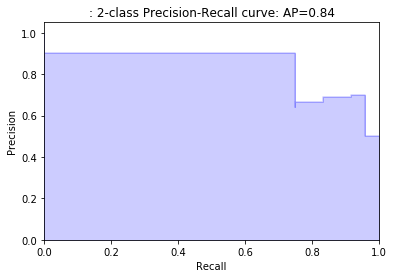

In [18]:
for md in [3]: #[1,2,3,4,5,6]:
    print('MAX DEPTH IS ' + str(md))
    label = '2visit_CKD_md_'+str(md)
    prediction, prob_a = loo_decision_tree(X, Y, feature_names_2v, max_depth = md, label=label)
    show_stats(Y, prediction, prob_a, '')

In [15]:
#pd.crosstab(list(Y), prediction, rownames=['Actual'], colnames=['Predicted'])

In [16]:
analysis_data_positive[['CKD? visit 1']]

,CKD? visit 1
0,Unknown
1,Unknown
2,Unknown
3,Unknown
4,Unknown
6,Unknown
7,Unknown
8,Unknown
9,Unknown
10,Unknown


In [17]:
# LOOKING AT INDIVIDUAL TREES TO SEE IF THEY CHANGE (THEY DO)

max_depth = 3
loo = LeaveOneOut()
loo.get_n_splits(X)
prediction = []
prob_a = []
i=-1
for train_index, test_index in loo.split(X):
    i +=1 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    clf = tree.DecisionTreeClassifier(max_depth = max_depth)
    clf = clf.fit(X_train, y_train)

    # make the tree pdf
    dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_names_2v, rounded=True, class_names = ['no CKD', 'CKD']) 
    graph = graphviz.Source(dot_data) 
    graph.render('trees/debug1_' + label +'_'+str(i)) 

    #prediction.append(clf.predict_proba(X_test))
    prediction.append(clf.predict(X_test)[0])
    prob_a.append(clf.predict_proba(X_test)[0][1])